In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sys
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../../../../")
from data_pipeline.score import field_names
from data_pipeline.comparison_tool.src import utils

pd.options.display.float_format = "{:,.3f}".format
%load_ext lab_black

# Comparator definition comparison

This notebook answers a few questions:
1. How many tracts are flagged and what's the size of overlap by comparator?
2. What are the demographics of each set of tracts by "category" of score (CEJST but not comparator, comparator but not CEJST, CEJST and comparator)?
3. What are the overall demographics of ALL comparator vs ALL CEJST?

It produces a single Excel file of the stats listed, but is interactive even after run-time. This notebook focuses on 1:1 comparison. It can be pointed in the YAML to either a simple output (tract and boolean for highlight) or to the output from an ETL.

In [3]:
## These are parameters and get overridden by the "injected parameters" cell below
ADDITIONAL_DEMO_COLUMNS = []
COMPARATOR_COLUMN = None
COMPARATOR_FILE = None
DEMOGRAPHIC_COLUMNS = []
DEMOGRAPHIC_FILE = None
OUTPUT_DATA_PATH = None
SCORE_FILE = None
OTHER_COMPARATOR_COLUMNS = None
OUTPUT_NAME = None

In [4]:
# Parameters
ADDITIONAL_DEMO_COLUMNS = [
    "Urban Heuristic Flag",
    "Percent of individuals below 200% Federal Poverty Line",
    "Percent individuals age 25 or over with less than high school degree",
    "Unemployment (percent)",
    "Percent of households in linguistic isolation",
]
COMPARATOR_COLUMN = "nyc_dac"
COMPARATOR_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/comparison_tool/data/nyc_dacs/clean/nyc_dac.csv"
DEMOGRAPHIC_COLUMNS = [
    "Percent Black or African American alone",
    "Percent American Indian and Alaska Native alone",
    "Percent Asian alone",
    "Percent Native Hawaiian and Other Pacific alone",
    "Percent Two or more races",
    "Percent Non-Hispanic White",
    "Percent Hispanic or Latino",
]
DEMOGRAPHIC_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/dataset/census_acs_2019/usa.csv"
OUTPUT_DATA_PATH = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/comparison_tool/output/nyc_dacs"
SCORE_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/score/csv/full/usa.csv"
OTHER_COMPARATOR_COLUMNS = [
    "Tribal_Designation",
    "Household_Low_Count_Flag",
    "Population_Count",
    "Household_Count",
    "Percentile_Rank_Combined_Statewide",
    "Percentile_Rank_Combined_NYC",
    "Percentile_Rank_Combined_ROS",
    "Combined_Score",
    "Burden_Score_Percentile",
    "Vulnerability_Score_Percentile",
    "Burden_Score",
    "Vulnerability_Score",
    "Benzene_Concentration",
    "Particulate_Matter_25",
    "Traffic_Truck_Highways",
    "Traffic_Number_Vehicles",
    "Wastewater_Discharge",
    "Housing_Vacancy_Rate",
    "Industrial_Land_Use",
    "Landfills",
    "Oil_Storage",
    "Municipal_Waste_Combustors",
    "Power_Generation_Facilities",
    "RMP_Sites",
    "Remediation_Sites",
    "Scrap_Metal_Processing",
    "Agricultural_Land_Use",
    "Coastal_Flooding_Storm_Risk",
    "Days_Above_90_Degrees_2050",
    "Drive_Time_Healthcare",
    "Inland_Flooding_Risk",
    "Low_Vegetative_Cover",
    "Asian_Percent",
    "Black_African_American_Percent",
    "Redlining_Updated",
    "Latino_Percent",
    "English_Proficiency",
    "Native_Indigenous",
    "LMI_80_AMI",
    "LMI_Poverty_Federal",
    "Population_No_College",
    "Household_Single_Parent",
    "Unemployment_Rate",
    "Asthma_ED_Rate",
    "COPD_ED_Rate",
    "Households_Disabled",
    "Low_Birth_Weight",
    "MI_Hospitalization_Rate",
    "Health_Insurance_Rate",
    "Age_Over_65",
    "Premature_Deaths",
    "Internet_Access",
    "Home_Energy_Affordability",
    "Homes_Built_Before_1960",
    "Mobile_Homes",
    "Rent_Percent_Income",
    "Renter_Percent",
]
OUTPUT_NAME = "nyc_dacs"

In [5]:
## These are constants for all runs
GEOID_COLUMN = field_names.GEOID_TRACT_FIELD
SCORE_COLUMN = field_names.SCORE_M_COMMUNITIES
TOTAL_POPULATION_COLUMN = field_names.TOTAL_POP_FIELD

__Date and time of last run__

In [6]:
datetime.datetime.now()

datetime.datetime(2022, 3, 15, 20, 19, 31, 230279)

__Congfigure output (autocreated)__

In [7]:
OUTPUT_EXCEL = os.path.join(
    OUTPUT_DATA_PATH,
    f"{OUTPUT_NAME}__{datetime.datetime.now().strftime('%Y-%m-%d')}.xlsx",
)

__Read in data__

In [8]:
comparator_cols = (
    [COMPARATOR_COLUMN] + OTHER_COMPARATOR_COLUMNS
    if OTHER_COMPARATOR_COLUMNS
    else [COMPARATOR_COLUMN]
)

# papermill_description=Loading_data
joined_frame = pd.concat(
    [
        utils.read_file(
            SCORE_FILE,
            columns=[TOTAL_POPULATION_COLUMN, SCORE_COLUMN] + ADDITIONAL_DEMO_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
        utils.read_file(COMPARATOR_FILE, columns=comparator_cols, geoid=GEOID_COLUMN),
        utils.read_file(
            DEMOGRAPHIC_FILE,
            DEMOGRAPHIC_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
    ],
    axis=1,
).reset_index()

# Comparator may provide simple list of tracts; this will fill all census tracts with "False"
joined_frame = joined_frame.fillna({COMPARATOR_COLUMN: False, SCORE_COLUMN: False})

## High-level summary

What *shares* of tracts and population highlighted by the comparator are covered by CEJST?

In [9]:
# papermill_description=Summary_stats
population = utils.produce_summary_stats(
    joined_frame, COMPARATOR_COLUMN, SCORE_COLUMN, TOTAL_POPULATION_COLUMN, GEOID_COLUMN
)
population

Population  Count of tracts  \
nyc_dac Definition M (communities)                                    
False   False                      230,211,727.000            50041   
        True                        89,094,870.000            22398   
True    False                        2,579,235.000              642   
        True                         4,404,139.000             1079   

                                    Share of tracts  Share of population  
nyc_dac Definition M (communities)                                        
False   False                                 0.675                0.706  
        True                                  0.302                0.273  
True    False                                 0.009                0.008  
        True                                  0.015                0.013

## Tract-level stats

First, this walks through overall stats for disadvantaged communities under the comparator definition and under the CEJST's definition. Next, this walks through stats by group (e.g., CEJST and not comparator). This is at the tract level, so the average across tracts, where tracts are not population-weighted. 

In [10]:
# papermill_description=Tract_stats
tract_level_by_identification = pd.concat(
    [
        utils.get_demo_series(
            COMPARATOR_COLUMN,
            joined_frame,
            ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
        ),
        utils.get_demo_series(
            SCORE_COLUMN, joined_frame, ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS
        ),
    ],
    axis=1,
)

tract_level_by_identification

,nyc_dac,Definition M (communities)
Urban Heuristic Flag,0.954,0.839
Percent of individuals below 200% Federal Poverty Line,0.442,0.530
Percent individuals age 25 or over with less than high school degree,0.208,0.225
Unemployment (percent),0.079,0.091
Percent of households in linguistic isolation,0.124,0.112
Percent Black or African American alone,0.265,0.250
Percent American Indian and Alaska Native alone,0.009,0.016
Percent Asian alone,0.075,0.040
Percent Native Hawaiian and Other Pacific alone,0.001,0.002
Percent Two or more races,0.042,0.034


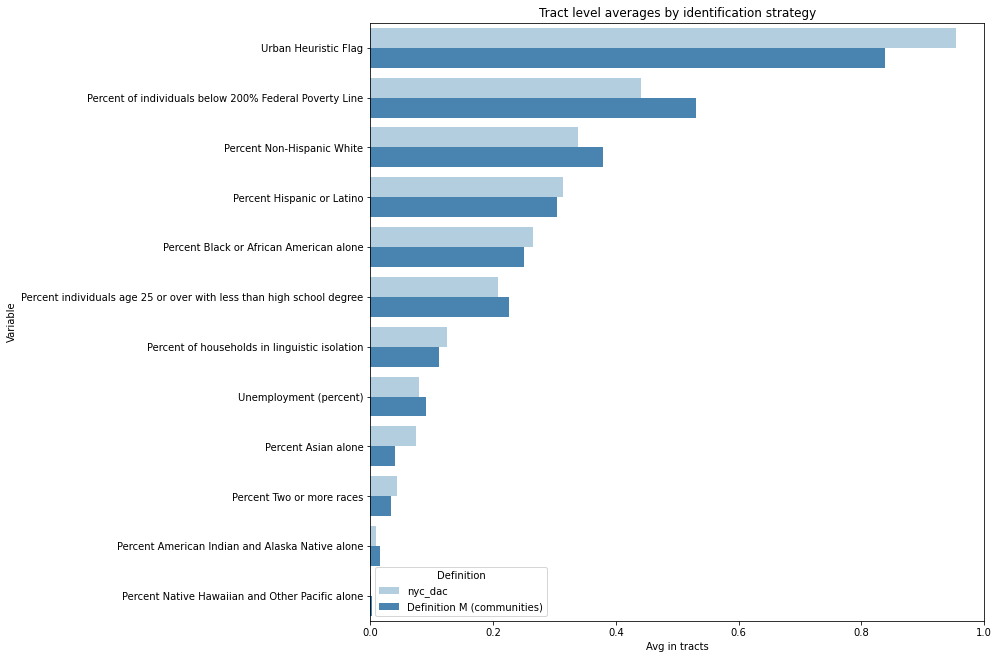

In [11]:
plt.figure(figsize=(11, 11))
sns.barplot(
    y="Variable",
    x="Avg in tracts",
    hue="Definition",
    data=tract_level_by_identification.sort_values(
        by=COMPARATOR_COLUMN, ascending=False
    )
    .stack()
    .reset_index()
    .rename(
        columns={"level_0": "Variable", "level_1": "Definition", 0: "Avg in tracts"}
    ),
    palette="Blues",
)
plt.xlim(0, 1)
plt.title("Tract level averages by identification strategy")
plt.savefig(os.path.join(OUTPUT_DATA_PATH, "tract_lvl_avg.jpg"), bbox_inches="tight")

In [12]:
# papermill_description=Tract_stats_grouped
tract_level_by_grouping = utils.get_tract_level_grouping(
    joined_frame,
    SCORE_COLUMN,
    COMPARATOR_COLUMN,
    ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
)

tract_level_by_grouping_formatted = utils.format_multi_index_for_excel(
    tract_level_by_grouping
)

In [13]:
tract_level_by_grouping_formatted

,Variable,"Not CEJST, Comparator","CEJST, Not Comparator","CEJST, Comparator"
0,Urban Heuristic Flag,0.901,0.831,0.985
1,Percent of individuals below 200% Federal Pove...,0.285,0.530,0.534
2,Percent individuals age 25 or over with less t...,0.131,0.224,0.254
3,Unemployment (percent),0.055,0.091,0.094
4,Percent of households in linguistic isolation,0.052,0.109,0.167
5,Percent Black or African American alone,0.199,0.247,0.305
6,Percent American Indian and Alaska Native alone,0.006,0.016,0.011
7,Percent Asian alone,0.065,0.038,0.080
8,Percent Native Hawaiian and Other Pacific alone,0.001,0.002,0.001
9,Percent Two or more races,0.039,0.034,0.044


## Population-weighted stats

In [14]:
# papermill_description=Population_stats
population_weighted_stats = pd.concat(
    [
        utils.construct_weighted_statistics(
            joined_frame,
            COMPARATOR_COLUMN,
            DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            TOTAL_POPULATION_COLUMN,
        ),
        utils.construct_weighted_statistics(
            joined_frame,
            SCORE_COLUMN,
            DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            TOTAL_POPULATION_COLUMN,
        ),
    ],
    axis=1,
)

## Print to excel

In [15]:
# papermill_description=Writing_excel
utils.write_single_comparison_excel(
    OUTPUT_EXCEL,
    population,
    tract_level_by_identification,
    population_weighted_stats,
    tract_level_by_grouping_formatted,
)

## Additional analysis (by hand)

In [28]:
ny_df = joined_frame[joined_frame["GEOID10_TRACT"].str.startswith("36")]

In [31]:
def _get_ny_only(df, col_list):
    return pd.concat(
        [
            df.groupby([SCORE_COLUMN])[col_list]
            .mean()
            .T.rename(columns={False: "Not CEJST", True: "CEJST"}),
            df.groupby([COMPARATOR_COLUMN])[col_list]
            .mean()
            .T.rename(columns={False: "Not NYC", True: "NYC"}),
        ],
        axis=1,
    )

In [32]:
_get_ny_only(ny_df, ADDITIONAL_DEMO_COLUMNS)

,Not CEJST,CEJST,Not NYC,NYC
Urban Heuristic Flag,0.831,0.976,0.838,0.954
Percent of individuals below 200% Federal Poverty Line,0.212,0.495,0.231,0.442
Percent individuals age 25 or over with less than high school degree,0.087,0.238,0.098,0.208
Unemployment (percent),0.046,0.083,0.046,0.079
Percent of households in linguistic isolation,0.036,0.178,0.059,0.124


In [33]:
_get_ny_only(ny_df, DEMOGRAPHIC_COLUMNS)

,Not CEJST,CEJST,Not NYC,NYC
Percent Black or African American alone,0.125,0.253,0.114,0.265
Percent American Indian and Alaska Native alone,0.003,0.008,0.003,0.009
Percent Asian alone,0.064,0.128,0.091,0.075
Percent Native Hawaiian and Other Pacific alone,0.000,0.001,0.000,0.001
Percent Two or more races,0.027,0.040,0.025,0.042
Percent Non-Hispanic White,0.678,0.297,0.670,0.339
Percent Hispanic or Latino,0.113,0.315,0.106,0.313


In [35]:
_get_ny_only(ny_df, OTHER_COMPARATOR_COLUMNS)[["CEJST", "NYC"]]

,CEJST,NYC
Population_Count,"3,901.905","4,055.193"
Household_Count,"1,385.880","1,504.567"
Percentile_Rank_Combined_Statewide,0.732,0.798
Percentile_Rank_Combined_NYC,0.429,0.429
Percentile_Rank_Combined_ROS,0.252,0.372
Combined_Score,"2,168.482","2,312.924"
Burden_Score_Percentile,0.559,0.683
Vulnerability_Score_Percentile,0.772,0.753
Burden_Score,34.384,37.793
Vulnerability_Score,62.748,61.868
